# MNIST手書き文字

生き物の模型として*drosophila*が生物学の各界で重宝されるように、機械学習の世界では、識別能力を試すときに使う実データとして、MNISTの手書き文字データがもっとも有名であろう。また、提供されているデータが二値（バイナリ）データなので、それを扱うことも良い練習である。本当にゼロとイチでの表現なので、読み書きの際は一定の注意が必要であるが、何も難しいことはない。

__目次__

- <a href="#overview">データセットの概要</a>

- <a href="#input_check">入力パターンを調べる</a>

- <a href="#label_check">ラベルを調べる</a>

- <a href="#make_h5">作業用のデータを整える</a>

___

<a id="overview"></a>
## データセットの概要

このデータセットの略称のMNISTは、米国の(N)ational (I)nstitute of (S)tandards and (T)echnologyがもともと管理していた大きな手書き文字データベースから一部を抜粋、調整した(m)odified subsetであることからきている。

<img src="img/ex_MNIST.png" alt="Stimuli Image" />

ダウンロード方法はいくつもあるが、Y. LeCun氏のサイト( http://yann.lecun.com/exdb/mnist/ )から入手することが多い。彼らの説明には、

> *"The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image"*

とあり、その中身を収容するファイルが下記の4つである。

> train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
> train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
> t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
> t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)

いずれも__IDX__という二値形式で保存されている。まずは圧縮されたファイルを解凍する。
```
$ cd data/MNIST
$ gunzip train-images-idx3-ubyte.gz
$ gunzip train-labels-idx1-ubyte.gz
$ gunzip t10k-images-idx3-ubyte.gz
$ gunzip t10k-labels-idx1-ubyte.gz
```
残るのは肝心のバイナリデータだけだ。
___

<a id="input_check"></a>
## 入力パターンを調べる

まずは、訓練データのファイルを開くことにしよう。

In [1]:

import numpy as np
import matplotlib.pyplot as plt

toread = "data/mnist/train-images-idx3-ubyte"

f_bin = open(toread, mode="rb")

print(f_bin)


<_io.BufferedReader name='data/mnist/train-images-idx3-ubyte'>


ここで、正しく読み込めているかどうか確かめる必要が出てくる。その唯一の方法は、データの提供者が「あるはずだ」という内容と照合することである。
LeCunらの説明より：

```
TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
```

ここでいう「offset」とは、ファイル開始点から何バイト読み進んだか示す数値である。ゼロならば一バイトも読んでおらず、1バイト目を目前にする地点である。offsetが0004であれば5バイト目、0008であれば9バイト目など、以下同様。期待どおりの中身が読み込めているかチェックしてみよう。

In [2]:
print("First four bytes:") # should be magic number, 2051.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))

First four bytes:
bytes:  b'\x00\x00\x08\x03'
 int:  2051


ここに出てきたPythonのバイトデータ`b'\x00\x00\x08\x03'`は、最初の4バイトを十六進法(hexadecimal)の表記で示したものである。上記の表の一行目の「value」、つまり``0x00000803``と一致しているので、一安心。これらの``\x``はただ単にバイトの区切りを表している。思い出してみると、十六進法の2桁を使うと、$0, 1, 2, \ldots$から$(15 \times 16^{1} + 15 \times 16^{0}) = 255$までの整数を表現することができる。二進法の8桁、つまり8ビット（＝1バイト）と同じである。さて、十進法に変換して$3 \times 16^{0} + 8 \times 16^{2} = 2051$が得られるので、期待どおりの「magic number」である。

次は、`read`というメソッドを使い、4バイトずつ読み進めるようにして、残りの内容を確認していく。

In [3]:

print("Second four bytes:") # should be number of imgs = 60000
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Second four bytes:
bytes:  b'\x00\x00\xea`'
 int:  60000


In [4]:

print("Third four bytes:") # should be number of rows = 28
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Third four bytes:
bytes:  b'\x00\x00\x00\x1c'
 int:  28


In [5]:

print("Fourth four bytes:") # should be number of cols = 28
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big", signed=False))


Fourth four bytes:
bytes:  b'\x00\x00\x00\x1c'
 int:  28


これでもっとも重要なファイル情報を無事に入手できた。これを使って、肝心の入力パターンを取り出していくことにしよう。幸いにも、デジタル画像の画素値なので、中身のもっともらしさは目視でほぼ確認できる。

In [7]:
n = 60000 # (anticipated) number of images.
d = 28*28 # number of entries (int values) per image.
times_todo = 5 # number of images to view.
bytes_left = d
data_x = np.zeros((d,), dtype=np.uint8) # initialize.

データの提供者の説明より：

> *"Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black)."*

つまり、画素値が0〜255の整数値を取り、2次元画像の一行ずつ読んでいくことになる。値の範囲がわかっているので、`uint8`(無符号の1バイト整数)のデータ型とする。まだ読んでいない中身として、
```
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
```
と1バイトずつファイルの最後まで読んでいくと、ちょうど60000枚の画像の全画素を読み込むことになるはずである。1枚につき画素数が$28 \times 28 = 784$である。

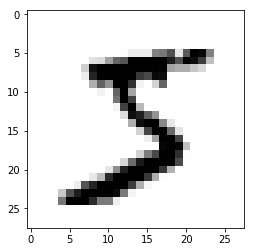

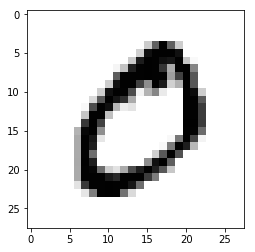

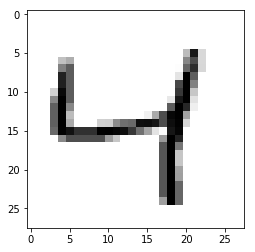

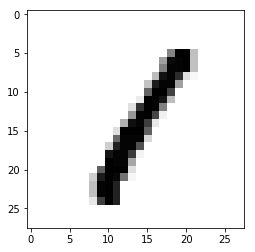

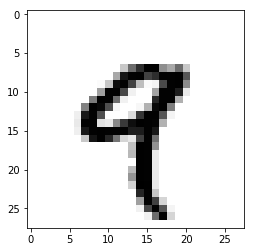

Successfully closed.


In [8]:
for t in range(times_todo):

    idx = 0
    while idx < bytes_left:
        # Iterate one byte at a time.
        b = f_bin.read(1)
        data_x[idx] = int.from_bytes(b, byteorder="big", signed=False)
        idx += 1

    img_x = data_x.reshape( (28,28) ) # populate one row at a time.
    
    # binary colour map highlights foreground (black) against background(white)
    plt.imshow(img_x, cmap=plt.cm.binary)
    #plt.savefig(("MNIST_train_"+str(t)+".png"))
    plt.show()


f_bin.close()
if f_bin.closed:
    print("Successfully closed.")

__練習問題__

0. 上記のコードに出没する`int`のメソッド`from_bytes`を使うとき、引数`signed`を`False`から`True`へ変えてみてください。変換の結果が変わるか。変わる場合は、例示しながら説明すること。なぜその変化が起こるかも併せて説明すること。

0. 同様に`byteorder`を`"big"`から`"little"`へ変換し、何がどう変わるか調べてみてください。背景は`help(int.from_bytes)`を参照すること。

0. 多数のカラーマップが提供されている( https://matplotlib.org/users/colormaps.html )。上記コード内の`binary`に代わって、たとえば`gray`、`bone`、`pink`などほかの配色方法を試してみてください。

0. コメント記号で無効になっている`savefig`を「活き」の状態にし、最初の十枚の画像をディスクに保存すること。また、テスト用のデータについても同様の操作を行うこと（ファイル名は適宜変更すること）。

<a id="label_check"></a>
## ラベルを調べる

「何が書いてあるか」という典型的な識別課題を見据えて、「事例」としての画像が正しく読み込まれている模様である。正解ラベルは`train-labels-idx1-ubyte`という別のファイルに格納されているため、次はラベルに焦点を当てる。最初の`times_todo`枚の画像と対応するはずのラベルを照らし合わせることにしよう。

In [9]:
toread = "data/mnist/train-labels-idx1-ubyte"

f_bin = open(toread, mode="rb")

print(f_bin)

<_io.BufferedReader name='data/mnist/train-labels-idx1-ubyte'>


正解ラベルのファイルについては、再びLeCun等の説明を参考にする：

```
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
```

最初の8バイトを見ていく。

In [10]:
print("First four bytes:") # should be magic number, 2049.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big"))

First four bytes:
bytes:  b'\x00\x00\x08\x01'
 int:  2049


In [11]:

print("Second four bytes:") # should be number of observations, 60000.
b = f_bin.read(4)
print("bytes: ", b)
print(" int: ", int.from_bytes(b, byteorder="big"))


Second four bytes:
bytes:  b'\x00\x00\xea`'
 int:  60000


以降はデータだけである。ラベルの値は0から9までの整数値を取るという。事例とラベルが一致していることを確かめる。

In [12]:
times_todo = 5 # number of images to view.

for t in range(times_todo):

    b = f_bin.read(1)
    mylabel = int.from_bytes(b, byteorder="big", signed=False)
    
    print("Label =", mylabel)


Label = 5
Label = 0
Label = 4
Label = 1
Label = 9


__練習問題__

0. 最初の10枚分のラベルを表示し、先ほど調べた画像の中身と合っているかどうか確かめること（訓練データと検証データ、両方とも）。

0. （おまけ） 上記のごとく`read`を使うと一方的に前進するだけだが、`seek`というメソッドを使うことで任意のバイトオフセットに飛ぶことができて、便利である。上の例でいうと、`f_bin.seek(0)`でファイル開始点に戻り、`f_bin.seek(8)`で最初のラベルを読み込む直前の地点へ移ることができる（最初の8バイトは補足情報）。この点を念頭において、`seek`を用いて、$k$という整数を与えられたときに$k$番目の画像の正解ラベルを表示するような関数を造りなさい。

0. （おまけ） 同様に、`seek`を使って$k$番目の画像を表示するような関数も造りなさい。

<a id="make_h5"></a>
## 作業用のデータを整える

このデータを使おうと思えば、上記のように正しく読み込むことはできるのだが、使うたびにいちいちバイトごとに読むことは煩雑である。なので、事前に一度だけバイナリデータから読み取ったデータを、前処理などを済ませた上で高速にアクセスできる別の形式に変換したほうが合理的であろう。

使い勝手の良い形式として、HDF5という階層型データを用いる。階層型デーの管理や高速な読み・書きを可能にした__PyTables__が大変便利である。このPythonのパッケージを駆使して、先ほどの画像（二次元の配列で表示）を単なる長いベクトルとして保存し、新しい二次元配列の「一行」が一つの画像に相当することになる。

まず、元のデータの全体を読み込む。

In [13]:
import tables
import numpy as np
import matplotlib.pyplot as plt
import os

In [14]:
# Key information.
NUM_CLASSES = 10
NUM_LABELS = 1
NUM_PIXELS = 28*28
NUM_TRAIN = 60000
NUM_TEST = 10000

In [15]:
# Open file connection, writing new file to disk.
myh5 = tables.open_file("data/mnist/data.h5",
                        mode="w",
                        title="MNIST handwritten digits with labels")
print(myh5) # currently empty.

data/mnist/data.h5 (File) 'MNIST handwritten digits with labels'
Last modif.: 'Fri Jul 27 08:48:13 2018'
Object Tree: 
/ (RootGroup) 'MNIST handwritten digits with labels'



`RootGroup`の下、さらに訓練・検証のためのグループを追加する。

In [16]:
myh5.create_group(myh5.root, "train", "Training data")
myh5.create_group(myh5.root, "test", "Testing data")
print(myh5)

data/mnist/data.h5 (File) 'MNIST handwritten digits with labels'
Last modif.: 'Fri Jul 27 08:48:13 2018'
Object Tree: 
/ (RootGroup) 'MNIST handwritten digits with labels'
/test (Group) 'Testing data'
/train (Group) 'Training data'



この2つのグループはそれぞれ、*enumerative array* (`EArray`クラス, 数え上げ配列)を持たせて、データを格納するための準備を始める。通常の`Array`オブジェクトと違って、あとでデータを追加することで伸ばし広げられる性質を有する。

In [17]:
# Training data arrays.
a = tables.UInt8Atom()
myh5.create_earray(myh5.root.train,
                   name="labels",
                   atom=a,
                   shape=(0,NUM_LABELS),
                   title="Label values")
a = tables.Float32Atom()
myh5.create_earray(myh5.root.train,
                   name="inputs",
                   atom=a,
                   shape=(0,NUM_PIXELS),
                   title="Input images")

# Testing data arrays.
a = tables.UInt8Atom()
myh5.create_earray(myh5.root.test,
                   name="labels",
                   atom=a,
                   shape=(0,NUM_LABELS),
                   title="Label values")
a = tables.Float32Atom()
myh5.create_earray(myh5.root.test,
                   name="inputs",
                   atom=a,
                   shape=(0,NUM_PIXELS),
                   title="Input images")

print(myh5)

data/mnist/data.h5 (File) 'MNIST handwritten digits with labels'
Last modif.: 'Fri Jul 27 08:48:13 2018'
Object Tree: 
/ (RootGroup) 'MNIST handwritten digits with labels'
/test (Group) 'Testing data'
/test/inputs (EArray(0, 784)) 'Input images'
/test/labels (EArray(0, 1)) 'Label values'
/train (Group) 'Training data'
/train/inputs (EArray(0, 784)) 'Input images'
/train/labels (EArray(0, 1)) 'Label values'



空っぽの配列ができているので、あとは埋めるだけである。1番目の次元は「伸張できる次元」と決まっており、最初はデータが入っていないのでゼロとなっているが、追加するたびに伸びていく。さて、データを読んでから簡単な前処理をしよう。

In [18]:
toread = "data/mnist/train-images-idx3-ubyte"
bytes_left = NUM_TRAIN*NUM_PIXELS
data_X = np.empty((NUM_TRAIN*NUM_PIXELS,), dtype=np.uint8)

with open(toread, mode="rb") as f_bin:

    f_bin.seek(16) # go to start of images.
    idx = 0
    
    print("Reading binary file...", end=" ")
    while bytes_left > 0:
        b = f_bin.read(1)
        data_X[idx] = int.from_bytes(b, byteorder="big", signed=False)
        bytes_left -= 1
        idx += 1
    print("Done reading...", end=" ")
print("OK, file closed.")

data_X = data_X.reshape((NUM_TRAIN,NUM_PIXELS))

Reading binary file... Done reading... OK, file closed.


符号無し整数型`uint8`を使って、全ピクセルの値を一本の長いベクトルに並べた。簡単な統計量を見てみよう。

In [19]:
print("Statistics before pre-processing:")
print("Min:", np.min(data_X))
print("Mean:", np.mean(data_X))
print("Median:", np.median(data_X))
print("Max:", np.max(data_X))
print("StdDev:", np.std(data_X))
#print(np.bincount(data_X))

Statistics before pre-processing:
Min: 0
Mean: 33.318421449829934
Median: 0.0
Max: 255
StdDev: 78.56748998339798


このデータを最終的に使うモデルによっては、入力の数値が大きすぎると計算が困難になる場合がある。今の画素値は$\{0,1,\ldots,255\}$から値を取るが、たとえば、ロジスティック回帰のように画素値の線形和を指数関数に渡すと、膨大な数になってしまう。これを回避すべく、単位区間$[0,1]$への正規化が便利である。もともとあるVALUEを(VALUE - MIN) / (MAX - MIN)という新しい値に変換させるだけである。浮動小数点数を使うので、より大きな容量を食うことになるが、その代わりに学習用のデータとしての有用性が高い。

In [20]:
data_X = np.float32(data_X)
data_X = (data_X - np.min(data_X)) / (np.max(data_X) - np.min(data_X))

print("Statistics after pre-processing:")
print("Min:", np.min(data_X))
print("Mean:", np.mean(data_X))
print("Median:", np.median(data_X))
print("Max:", np.max(data_X))
print("StdDev:", np.std(data_X))

Statistics after pre-processing:
Min: 0.0
Mean: 0.13066062
Median: 0.0
Max: 1.0
StdDev: 0.30810776


次は訓練用のラベルを読み込む。取る値は$0,1,\ldots,9$なので、前処理なしで、そのまま使える。

In [21]:
toread = "data/mnist/train-labels-idx1-ubyte"
bytes_left = NUM_TRAIN
data_y = np.zeros((NUM_TRAIN,1), dtype=np.uint8)

with open(toread, mode="rb") as f_bin:

    f_bin.seek(8) # go to start of the labels.
    idx = 0
    
    print("Reading binary file...", end=" ")
    while bytes_left > 0:
        b = f_bin.read(1)
        data_y[idx,0] = int.from_bytes(b, byteorder="big", signed=False)
        bytes_left -= 1
        idx += 1
    print("Done reading...", end=" ")
print("OK, file closed.")


Reading binary file... Done reading... OK, file closed.


Min: 0
Mean: 4.4539333333333335
Median: 4.0
Max: 9
StdDev: 2.889246360020012
Bin counts:
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


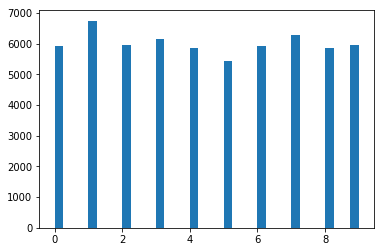

In [22]:
print("Min:", np.min(data_y))
print("Mean:", np.mean(data_y))
print("Median:", np.median(data_y))
print("Max:", np.max(data_y))
print("StdDev:", np.std(data_y))

print("Bin counts:")
print(np.bincount(data_y[:,0]))

plt.hist(np.hstack(data_y), bins='auto')
plt.show()

いよいよ階層型のデータファイルに追加するときがきた。その作業は簡単で、`append`というメソッドを使うとすぐにできる。

In [23]:
for i in range(NUM_TRAIN):
    myh5.root.train.inputs.append([data_X[i,:]])
    myh5.root.train.labels.append([data_y[i,:]])
print(myh5)

期待通りに、`train`というグループにデータが追加されたことは確認できた。

あとは検証用の分に対して、同じ一連の操作をする。

In [24]:
toread = "data/mnist/t10k-images-idx3-ubyte"
bytes_left = NUM_TEST*NUM_PIXELS
data_X = np.empty((NUM_TEST*NUM_PIXELS,), dtype=np.uint8)

with open(toread, mode="rb") as f_bin:

    f_bin.seek(16) # go to start of images.
    idx = 0
    
    print("Reading binary file...", end=" ")
    while bytes_left > 0:
        b = f_bin.read(1)
        data_X[idx] = int.from_bytes(b, byteorder="big", signed=False)
        bytes_left -= 1
        idx += 1
    print("Done reading...", end=" ")
print("OK, file closed.")

data_X = data_X.reshape((NUM_TEST,NUM_PIXELS))
data_X = np.float32(data_X)
data_X = (data_X - np.min(data_X)) / (np.max(data_X) - np.min(data_X))

toread = "data/mnist/t10k-labels-idx1-ubyte"
bytes_left = NUM_TEST
data_y = np.zeros((NUM_TEST,1), dtype=np.uint8)

with open(toread, mode="rb") as f_bin:

    f_bin.seek(8) # go to start of the labels.
    idx = 0
    
    print("Reading binary file...", end=" ")
    while bytes_left > 0:
        b = f_bin.read(1)
        data_y[idx,0] = int.from_bytes(b, byteorder="big", signed=False)
        bytes_left -= 1
        idx += 1
    print("Done reading...", end=" ")
print("OK, file closed.")

Reading binary file... Done reading... OK, file closed.
Reading binary file... Done reading... OK, file closed.


In [25]:
for i in range(NUM_TEST):
    myh5.root.test.inputs.append([data_X[i,:]])
    myh5.root.test.labels.append([data_y[i,:]])

In [26]:
print(myh5)

data/mnist/data.h5 (File) 'MNIST handwritten digits with labels'
Last modif.: 'Fri Jul 27 09:08:48 2018'
Object Tree: 
/ (RootGroup) 'MNIST handwritten digits with labels'
/test (Group) 'Testing data'
/test/inputs (EArray(10000, 784)) 'Input images'
/test/labels (EArray(10000, 1)) 'Label values'
/train (Group) 'Training data'
/train/inputs (EArray(60000, 784)) 'Input images'
/train/labels (EArray(60000, 1)) 'Label values'



最後に、ファイルとの接続を正常に閉じることが重要である。

In [27]:
myh5.close()

__練習問題__

0. 先ほど作成したファイル（`data.h5`)を再び開く（今度は読み込み、`mode="r"`）。訓練データ、検証データ、それぞれから数点の画像とラベルのペアを取り出して、前の節と同様に画像として表示して、内容が正しく保存されていることを確認すること。

___